### Описание

**Данные: E-Commerce Data** 
Описание: 'This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.'

Имеются следующие данные о транзакциях в период с 01.12.2010 по 12.09.2011:

InvoiceNo — номер транзакции  
StockCode — код товара  
Description — описание товара  
Quantity — количество единиц товара, добавленных в заказ  
InvoiceDate — дата транзакции   
UnitPrice — цена за единицу товара  
CustomerID — id клиента  
Country — страна, где проживает клиент  
  
Данные содержат в себе записи как об успешных транзакциях, так и об отмененных. В данных встречаются строки с Description 'Manual', которые включают данные об удаленных из чека позициях.


#### Особенности

*Датасет находится в Clickhouse, причем доступен только для чтения, что делает невозможным создание представлений, и (специфика СУБД) вынесение подзапросов в CTE. Будем выкручиваться.*

### Задачи
* Проанализировать продажи на внутреннем рынке UK, сгруппировав покупателей в когорты по числу покупок - средствами SQL (Clickhouse).   
* Проанализировать динамику выручки и продаж в динамике в течение года.   
* Оценить новых и повторных клиентов в динамике за 2011 год.  
* Построить таблицу Retention rate средствами SQL.

In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [4]:
with open('connection') as c:
    passw = c.read().strip()

In [5]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password': passw
                     }

In [6]:
def select(sql):
    return ph.read_clickhouse(sql, connection=connection_default)

### Чтение и подготовка данных

In [7]:
sql = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country

 
from default.retail
limit 1000
'''

In [8]:
select(sql)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 11:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 11:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 11:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 11:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 11:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
995,536520,22100,SKULLS SQUARE TISSUE BOX,1,2010-12-01 15:43:00,1.25,14729,United Kingdom
996,536520,22096,PINK PAISLEY SQUARE TISSUE BOX,1,2010-12-01 15:43:00,1.25,14729,United Kingdom
997,536520,22583,PACK OF 6 HANDBAG GIFT BOXES,1,2010-12-01 15:43:00,2.55,14729,United Kingdom
998,536520,21358,TOAST ITS - HAPPY BIRTHDAY,2,2010-12-01 15:43:00,1.25,14729,United Kingdom


In [9]:
sql = '''
select count(*) 
from retail
'''

In [10]:
select(sql)

,count()
0,406829


Нам известно, что в данных есть удаленные из чека позиции с описанием 'Manual'. Посмотрим на них подробнее.

In [11]:
sql = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
 
from default.retail
where Description = 'Manual'
limit 1000
'''

In [12]:
select(sql)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C561198,M,Manual,-35,2011-07-25 17:45:00,1.25,16161,United Kingdom
1,C561628,M,Manual,-1,2011-07-28 17:10:00,9.60,16422,United Kingdom
2,C561703,M,Manual,-1,2011-07-29 14:07:00,1.65,12709,Germany
3,C561725,M,Manual,-1,2011-07-29 15:10:00,3.25,17841,United Kingdom
4,561885,M,Manual,2,2011-07-31 16:13:00,4.95,15532,United Kingdom
...,...,...,...,...,...,...,...,...
460,580956,M,Manual,4,2011-12-06 18:23:00,1.25,17841,United Kingdom
461,C581009,M,Manual,-1,2011-12-07 13:15:00,125.00,16971,United Kingdom
462,C581145,M,Manual,-1,2011-12-07 17:48:00,9.95,17490,United Kingdom
463,581405,M,Manual,3,2011-12-08 17:50:00,0.42,13521,United Kingdom


Мы видим, что ручное удаление позиции из чека бывает как в успешных транзакциях, так и в отмененных. Отмененные выглядят как отрицательное значение в столбце Quantity и буква C в начале InvoiceNo. Для дальнейшего анализа исплючим эти позиции (Manual) и будем учитывать отмены заказов.  
Проверим данные на дубликаты

In [13]:
sql = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
 
from default.retail
where Description != 'Manual'
group by InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
having count(*) > 1
'''

In [14]:
select(sql)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,541886,20713,JUMBO BAG OWLS,10,2011-01-24 14:21:00,1.95,15039,United Kingdom
1,569823,22435,SET OF 9 HEART SHAPED BALLOONS,1,2011-10-06 15:15:00,1.25,16895,United Kingdom
2,559894,81950V,FLOWER PURPLE CLOCK WITH SUCKER,1,2011-07-13 15:06:00,0.29,14159,United Kingdom
3,559876,20973,12 PENCIL SMALL TUBE WOODLAND,1,2011-07-13 14:09:00,0.65,15752,United Kingdom
4,578781,23571,TRADITIONAL NAUGHTS & CROSSES,2,2011-11-25 15:54:00,1.65,15872,United Kingdom
...,...,...,...,...,...,...,...,...
4831,545188,22726,ALARM CLOCK BAKELIKE GREEN,1,2011-02-28 18:19:00,3.75,14056,United Kingdom
4832,576274,22423,REGENCY CAKESTAND 3 TIER,1,2011-11-14 18:24:00,12.75,17793,United Kingdom
4833,539317,22443,GROW YOUR OWN HERBS SET OF 3,1,2010-12-16 22:04:00,7.95,17392,United Kingdom
4834,564556,23158,SET OF 5 LUCKY CAT MAGNETS,1,2011-08-25 22:48:00,2.08,12748,United Kingdom


Почти 5000 строк дублируются, для дальнейшего анализа сгруппируем данные, чтобы дубликатов не было.

In [15]:
sql = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
 
from default.retail
where Description != 'Manual'
group by InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
having count(*) == 1
'''

In [16]:
select(sql)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,548863,21733,RED HANGING HEART T-LIGHT HOLDER,1,2011-04-04 16:57:00,2.95,15311,United Kingdom
1,546530,22554,PLASTERS IN TIN WOODLAND ANIMALS,96,2011-03-14 16:25:00,1.65,17404,Sweden
2,580523,20828,GLITTER BUTTERFLY CLIPS,2,2011-12-04 19:00:00,2.55,17827,United Kingdom
3,576601,23332,IVORY WICKER HEART LARGE,1,2011-11-15 19:10:00,1.65,14595,United Kingdom
4,570862,21703,BAG 125g SWIRLY MARBLES,24,2011-10-12 18:35:00,0.42,17528,United Kingdom
...,...,...,...,...,...,...,...,...
396303,552710,23175,REGENCY MILK JUG PINK,6,2011-05-11 10:35:00,3.25,13098,United Kingdom
396304,547652,21555,CERAMIC STRAWBERRY TRINKET TRAY,1,2011-03-24 15:15:00,2.55,14606,United Kingdom
396305,576274,23506,MINI PLAYING CARDS SPACEBOY,1,2011-11-14 18:24:00,0.42,17793,United Kingdom
396306,550714,22652,TRAVEL SEWING KIT,10,2011-04-20 14:12:00,1.65,15249,United Kingdom


Посмотрим на количество и сумму заказов по странам.

In [17]:
sql = '''
select Country,
        sum(Quantity * UnitPrice) as revenue,
        count(InvoiceNo) as counts
        
        from(
            select InvoiceNo, 
                    StockCode, 
                    Description, 
                    Quantity, 
                    toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
                    toFloat64(UnitPrice) as UnitPrice, 
                    CustomerID, 
                    Country

            from default.retail
            where Description != 'Manual'
            group by InvoiceNo, 
                    StockCode, 
                    Description, 
                    Quantity, 
                    toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
                    toFloat64(UnitPrice) as UnitPrice, 
                    CustomerID, 
                    Country
            having count(*) == 1)
    group by Country
    order by counts DESC
'''

In [18]:
select(sql)

,Country,revenue,counts
0,United Kingdom,6.783448e+06,351585
1,Germany,2.212519e+05,9449
2,France,1.965497e+05,8449
3,EIRE,2.508395e+05,7460
4,Spain,5.758010e+04,2520
5,Netherlands,2.847671e+05,2370
6,Belgium,4.091096e+04,2069
7,Switzerland,5.573940e+04,1877
8,Portugal,2.894676e+04,1449
9,Australia,1.369423e+05,1257


Всего продажи идут в 36 странах. Но так как на внутреннем рынке продаж кратно больше, мы будем анализировать именно движения по внутреннему рынку

In [19]:
sql = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
 
from default.retail
where Description != 'Manual' and Country == 'United Kingdom'
group by InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
having count(*) == 1
'''

In [20]:
select(sql)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,548863,21733,RED HANGING HEART T-LIGHT HOLDER,1,2011-04-04 16:57:00,2.95,15311,United Kingdom
1,580523,20828,GLITTER BUTTERFLY CLIPS,2,2011-12-04 19:00:00,2.55,17827,United Kingdom
2,576601,23332,IVORY WICKER HEART LARGE,1,2011-11-15 19:10:00,1.65,14595,United Kingdom
3,570862,21703,BAG 125g SWIRLY MARBLES,24,2011-10-12 18:35:00,0.42,17528,United Kingdom
4,543449,22470,HEART OF WICKER LARGE,12,2011-02-08 15:12:00,2.95,16553,United Kingdom
...,...,...,...,...,...,...,...,...
351580,570826,22109,FULL ENGLISH BREAKFAST PLATE,1,2011-10-12 16:14:00,3.75,16753,United Kingdom
351581,542247,21415,CLAM SHELL SMALL,6,2011-01-26 18:49:00,2.10,12997,United Kingdom
351582,576274,23506,MINI PLAYING CARDS SPACEBOY,1,2011-11-14 18:24:00,0.42,17793,United Kingdom
351583,550714,22652,TRAVEL SEWING KIT,10,2011-04-20 14:12:00,1.65,15249,United Kingdom


Также для дальнейшего удобства сохраним отдельно подзапрос для покупок и для возвратов (с Quantity < 0)

In [21]:
df_purchases = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
 
from default.retail
where Description != 'Manual' and Country == 'United Kingdom' and Quantity > 0
group by InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
having count(*) == 1
'''

In [22]:
df_cancelled = '''
select InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
 
from default.retail
where Description != 'Manual' and Country == 'United Kingdom' and Quantity < 0
group by InvoiceNo, 
        StockCode, 
        Description, 
        Quantity, 
        toDateTime(toUnixTimestamp(InvoiceDate)) as InvoiceDate, 
        toFloat64(UnitPrice) as UnitPrice, 
        CustomerID, 
        Country
having count(*) == 1
'''

### Разделение по категориям по числу покупок

Присвоим каждому покупателю категорию по количеству заказов. Категория А - покупатели, совершившие всего один заказ, B - от 2 до 4, С - от 5 до 9, D  более 10.

In [23]:
categories = f'''
        select  CustomerID,
                count(distinct  InvoiceNo ) as orders_count,
                sum(Quantity * UnitPrice) as orders_sum,
                case 
                     when  orders_count == 1 then 'A: 1'
                     when  orders_count > 1 and orders_count < 5 then 'B: 2-4'
                     when  orders_count >=5 and orders_count < 10 then 'C: 5-9'
                     when  orders_count >=10 then 'D: 10+'
                else 'mistake'
                end 
                        as segment
                 
            from     
                 ({df_purchases})  
            group by  CustomerID
            order by orders_count DESC

'''

In [24]:
select(categories)

,CustomerID,orders_count,orders_sum,segment
0,12748,206,31051.49,D: 10+
1,17841,124,40080.37,D: 10+
2,13089,97,58698.33,D: 10+
3,14606,92,11980.65,D: 10+
4,15311,91,60497.60,D: 10+
...,...,...,...,...
3913,13932,1,307.40,A: 1
3914,17970,1,552.89,A: 1
3915,13682,1,59.50,A: 1
3916,18262,1,149.48,A: 1


Посмотрим на количество покупателей и заказов, а также сумму заказов в каждой категории.

In [25]:
sql = f'''
        select segment, 
                count(distinct CustomerID) as customers_count,
                sum(orders_count) as orders_count,
                sum(orders_sum) as orders_sum
        from ({categories})
        group by segment
        order by segment
'''

In [26]:
select(sql)

,segment,customers_count,orders_count,orders_sum
0,A: 1,1352,1352,517167.031
1,B: 2-4,1559,4281,1648289.963
2,C: 5-9,654,4196,1478019.320
3,D: 10+,353,6779,3600164.950


Как мы видим, повторные покупатели приносят нам гораздо больше выручки, хотя их гораздо меньше. Но в этой таблице не учтены возвраты, может, они и возвращают больше? 

In [27]:
sql = f'''
   select segment,
         count(distinct CustomerID) as customers_cans_count,
         count(distinct  InvoiceNo) as cancelled_orders,
                sum(Quantity * UnitPrice) as cancelled_orders_sum
    from    
        (select p.*,
        c.segment as segment
        
    from ({df_cancelled}) as p
    left join ({categories}) as c 
    on p.CustomerID = c.CustomerID)
    group by segment
        order by segment

'''

In [28]:
select(sql)

,segment,customers_cans_count,cancelled_orders,cancelled_orders_sum
0,,25,28,-2876.18
1,A: 1,182,201,-85164.31
2,B: 2-4,497,731,-221291.04
3,C: 5-9,394,810,-30893.82
4,D: 10+,289,1341,-119967.52


Мы видим, что наше предположение не подтверждается, покупатели, которые покупают чаще, не делают больше возвратов. Напротив, сумма возвратов больше всего в категории "от 2 до 4 покупок". Часть покпателей с неопределенным сегментом - это, вероятно, покупатели, купившие в предыдущем учетном периоде и вернувшие товар сейчас. Таких немного, так что на общую картину они не особо влияют. Посчитаем процент возвратов для каждой категории

In [29]:
sql = f'''

    select l.segment,
    orders_count,
    orders_sum,
    cancelled_orders,
    cancelled_orders_sum,
    round(cancelled_orders / (orders_count) * 100, 2) as percentage_of_orders_count,
    round(cancelled_orders_sum / (orders_sum) * -100, 2) as percentage_of_orders_sum

    
  from
  (select segment, 
                count(distinct CustomerID) as customers_count,
                sum(orders_count) as orders_count,
                sum(orders_sum) as orders_sum
        from ({categories})
        group by segment
        order by segment) as l
     join 
     (select segment,
         count(distinct CustomerID) as customers_cans_count,
         count(distinct  InvoiceNo) as cancelled_orders,
                sum(Quantity * UnitPrice) as cancelled_orders_sum
    from    
        (select p.*,
        c.segment as segment
        
    from ({df_cancelled}) as p
    left join ({categories}) as c 
    on p.CustomerID = c.CustomerID)
    group by segment
        order by segment
) as r on r.segment = l.segment 

order by segment
  '''

In [30]:
select(sql)

,segment,orders_count,orders_sum,cancelled_orders,cancelled_orders_sum,percentage_of_orders_count,percentage_of_orders_sum
0,A: 1,1352,517167.031,201,-85164.31,14.87,16.47
1,B: 2-4,4281,1648289.963,731,-221291.04,17.08,13.43
2,C: 5-9,4196,1478019.320,810,-30893.82,19.30,2.09
3,D: 10+,6779,3600164.950,1341,-119967.52,19.78,3.33


#### Вывод
Таким образом, количество отмененных заказов в процентном соотношении примерно равно для всех категорий, но сумма возвратов относительно суммы покупок для покупателей, совершивших 5 и более покупок - значительно ниже!

### Динамика продаж в течение года

Посчитаем количество уникальных покупателей, заказов, выручку, средний чек и среднюю выручку на покупателя по месяцам. 

In [31]:
sql = f'''
    select toStartOfMonth(InvoiceDate ) as buy_month,
        segment,
       count(distinct CustomerID) as uniq_clients,
       count(distinct InvoiceNo ) as count_purchases,
       sum( Quantity * UnitPrice ) as revenue,
       revenue / count_purchases as avg_check,
       revenue / uniq_clients as arpu

from
        (select p.*,
                c.segment as segment

            from ({df_purchases}) as p
            left join ({categories}) as c 
            on p.CustomerID = c.CustomerID)
group by buy_month, segment
order by buy_month, segment
  '''

In [32]:
df_dinamic = select(sql)

In [33]:
df_dinamic.head()

,buy_month,segment,uniq_clients,count_purchases,revenue,avg_check,arpu
0,2010-12-01,A: 1,101,101,26535.09,262.723663,262.723663
1,2010-12-01,B: 2-4,249,279,79999.07,286.735018,321.281406
2,2010-12-01,C: 5-9,225,308,99394.68,322.710000,441.754133
3,2010-12-01,D: 10+,240,601,288315.26,479.725890,1201.313583
4,2011-01-01,A: 1,65,65,95744.20,1472.987692,1472.987692


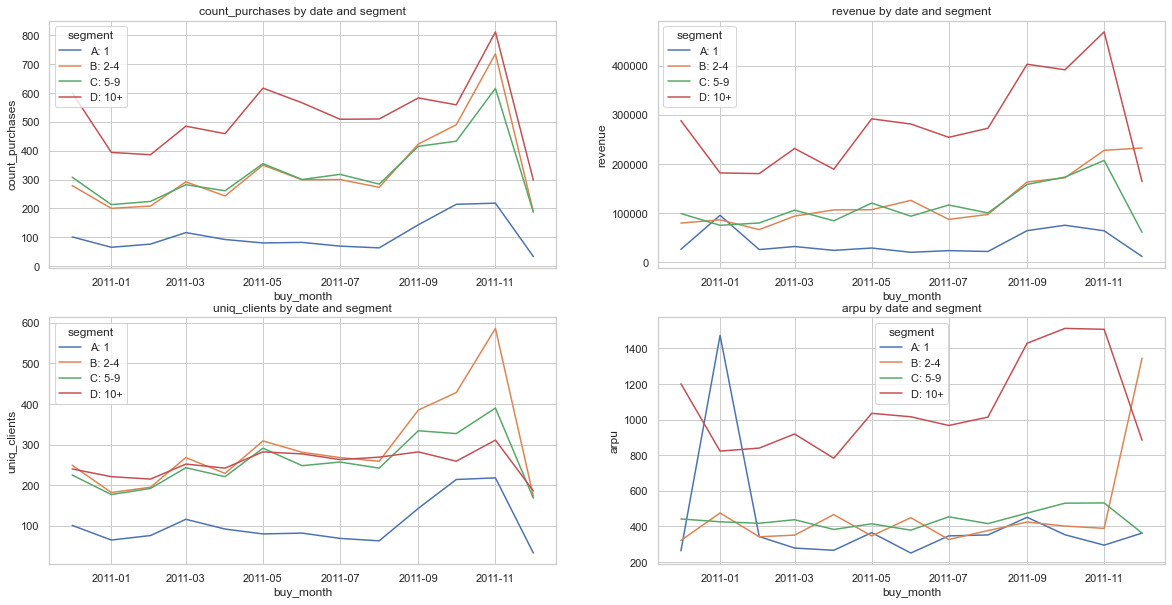

In [34]:
metrics = ['count_purchases', 'revenue', 'uniq_clients', 'arpu']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
for metric, ax in zip(metrics, axes):
    sns.lineplot(data=df_dinamic, x='buy_month', y=metric, hue='segment', ax=ax)
    ax.set_title(f'{metric} by date and segment')

#### Вывод
Выручка, число клиентов и число продаж имеют тренд на повышение за 2011 год, причем в основном за счет клиентов, совершающих повторные покупки. Средняя выручка на пользователя растет преимущественно в сегменте часто покупающих клиентов. Чем же обусловлен скачок ARPU у 1 сегмента в январе и у 2 в декабре?

In [35]:
sql = f'''
select 
        c.segment as segment, 
        p.CustomerID as CustomerID,
        p.InvoiceNo as InvoiceNo,
        p.InvoiceDate as InvoiceDate,
        p.Quantity as Quantity,
        p.UnitPrice as UnitPrice,
        Quantity*UnitPrice as Revenue,
        SUM(Revenue) over (partition by segment) as TotalRevenueBySegment,
        SUM(Revenue) over () as TotalRevenue,
        AVG(Revenue) over (partition by CustomerID) as arpu,
        AVG(Revenue) over (partition by InvoiceNo) as avg_check
    from ({df_purchases}) as p
    left join ({categories}) as c 
    on p.CustomerID = c.CustomerID
    order by Quantity DESC
    limit 10
    
'''

In [36]:
select(sql)

,segment,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Revenue,TotalRevenueBySegment,TotalRevenue,arpu,avg_check
0,B: 2-4,16446,581483,2011-12-09 13:15:00,80995,2.08,168469.60,1648289.963,7.243641e+06,56157.50000,168469.600000
1,A: 1,12346,541431,2011-01-18 13:01:00,74215,1.04,77183.60,517167.031,7.243641e+06,77183.60000,77183.600000
2,A: 1,13256,578841,2011-11-25 19:57:00,12540,0.00,0.00,517167.031,7.243641e+06,0.00000,0.000000
3,D: 10+,12901,573008,2011-10-27 15:26:00,4800,0.21,1008.00,3600164.950,7.243641e+06,152.19431,95.580000
4,A: 1,13135,554868,2011-05-27 13:52:00,4300,0.72,3096.00,517167.031,7.243641e+06,3096.00000,3096.000000
5,A: 1,18087,544612,2011-02-22 13:43:00,3906,0.82,3202.92,517167.031,7.243641e+06,3202.92000,3202.920000
6,B: 2-4,14609,560599,2011-07-19 20:04:00,3186,0.06,191.16,1648289.963,7.243641e+06,150.39000,191.160000
7,B: 2-4,15749,550461,2011-04-18 16:20:00,3114,2.10,6539.40,1648289.963,7.243641e+06,4453.43000,4307.180000
8,B: 2-4,15749,540815,2011-01-11 15:55:00,3114,2.10,6539.40,1648289.963,7.243641e+06,4453.43000,5053.633333
9,B: 2-4,16308,573995,2011-11-02 15:24:00,3000,0.32,960.00,1648289.963,7.243641e+06,640.00000,960.000000


А это все благодаря всего 2м аномально большим заказам.

### Новые и повторные клиенты в динамике

Посмотрим в динамике по месяцам, сколько каждый месяц приходит новых клиентов, и сколько повторных (оценим, как хорошо мы удерживаем старых клиентов и привлекаем новых).  
Для этого вычислим месяц первой покупки для каждого клиента, количество всех клиентов за месяц, и вычтя из второго первое получим число клиентов, совершивших повторную покупку.


In [37]:
first_month = f'''

select  CustomerID ,
            min(toStartOfMonth( InvoiceDate ) )as first_buy_month
            
            from ({df_purchases})
            group by CustomerID
            order by CustomerID'''

In [38]:
select(first_month)

,CustomerID,first_buy_month
0,12346,2011-01-01
1,12747,2010-12-01
2,12748,2010-12-01
3,12749,2011-05-01
4,12820,2011-01-01
...,...,...
3913,18280,2011-03-01
3914,18281,2011-06-01
3915,18282,2011-08-01
3916,18283,2011-01-01


In [39]:
new_customers_by_month = f'''
select first_buy_month,
        count(CustomerID) as count_1st_customers


from ({first_month})


group by first_buy_month
'''

In [40]:
select(new_customers_by_month)

,first_buy_month,count_1st_customers
0,2010-12-01,815
1,2011-01-01,357
2,2011-02-01,340
3,2011-03-01,419
4,2011-04-01,277
5,2011-05-01,256
6,2011-06-01,214
7,2011-07-01,168
8,2011-08-01,141
9,2011-09-01,276


In [41]:
all_customers_by_month = f'''
 select   toStartOfMonth( InvoiceDate ) as buy_month,
            count(distinct  CustomerID ) as clients 
    from ({df_purchases})
    group by buy_month
'''

In [42]:
select(all_customers_by_month)

,buy_month,clients
0,2010-12-01,815
1,2011-01-01,645
2,2011-02-01,678
3,2011-03-01,879
4,2011-04-01,784
5,2011-05-01,962
6,2011-06-01,888
7,2011-07-01,857
8,2011-08-01,833
9,2011-09-01,1144


In [43]:
sql = f'''
select l.first_buy_month as buy_month,
        l.count_1st_customers as new_customers,
        r.clients - l.count_1st_customers as returned_customers,
        r.clients as all_customers
        
        
from ({new_customers_by_month}) as l
join ({all_customers_by_month}) as r 
on l.first_buy_month = r.buy_month
where l.first_buy_month != '2010-12-01'
order by l.first_buy_month
'''

In [44]:
new_and_returned_customers = select(sql)

In [45]:
new_and_returned_customers

,buy_month,new_customers,returned_customers,all_customers
0,2011-01-01,357,288,645
1,2011-02-01,340,338,678
2,2011-03-01,419,460,879
3,2011-04-01,277,507,784
4,2011-05-01,256,706,962
5,2011-06-01,214,674,888
6,2011-07-01,168,689,857
7,2011-08-01,141,692,833
8,2011-09-01,276,868,1144
9,2011-10-01,323,905,1228


In [46]:
new_and_returned_customers.columns

Index(['buy_month', 'new_customers', 'returned_customers', 'all_customers'], dtype='object')

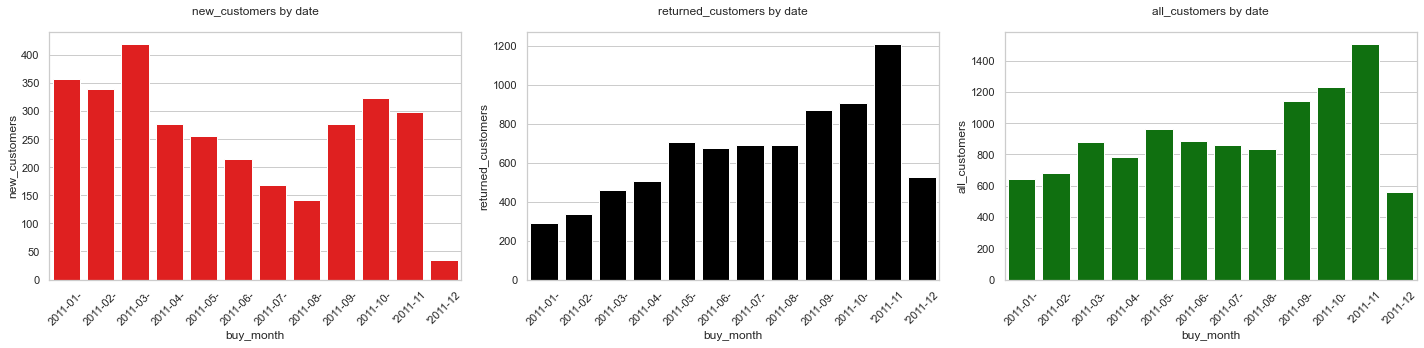

In [47]:
colors=['red' , 'black', 'green']
metrics = ['new_customers', 'returned_customers', 'all_customers']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()
for metric, ax, color in zip(metrics, axes, colors):
    sns.barplot(data=new_and_returned_customers, x='buy_month', y=metric, ax=ax, color=color)
    ax.set_title(f'{metric} by date\n')
    ax.set_xticklabels([str(i)[12:20] for i in ax.get_xticklabels()])
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
fig.tight_layout()

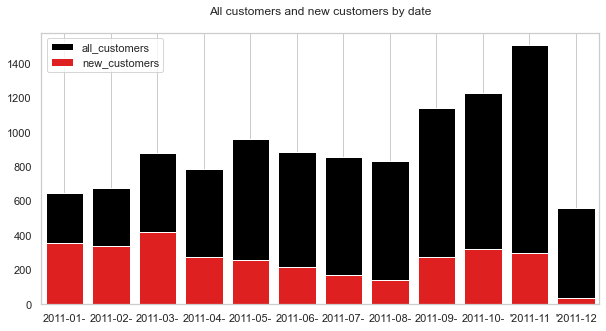

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(data=new_and_returned_customers, x='buy_month', 
            y='all_customers', color='black', ax=ax, label='all_customers')
sns.barplot(data=new_and_returned_customers, x='buy_month', 
            y='new_customers', color='red',  ax=ax, label='new_customers')
ax.set_xticklabels([str(i)[12:20] for i in ax.get_xticklabels()])
ax.set_title('All customers and new customers by date\n')
ax.set_ylabel('\n')
ax.set_xlabel('\n')
plt.legend()
plt.grid()

#### Вывод
Как мы видим на графиках, общее количество клиентов в 2011 году каждый месяц растет (провал последнего месяца объясняется неполными данными - у нас есть данные только за 9 дней декабря 2011). Хотя количество повторных клиентов в динамике растет, но число новых клиентов при этом снижается. Возможно, это проблема, на которую стоит обратить внимание (если емкость рынка не исчерпана) - например, увеличить маркетинговый бюджет на привлечение новых покупателей.

### Retention rate SQL

In [49]:
sql = f'''
select first_month as cohort,
sum(CASE WHEN months = 0 THEN 1 ELSE 0 END) as customers,
sum(CASE WHEN months = 1 THEN 1 ELSE 0 END) as month_2,
sum(CASE WHEN months = 2 THEN 1 ELSE 0 END) as month_3,
sum(CASE WHEN months = 3 THEN 1 ELSE 0 END) as month_4,
sum(CASE WHEN months = 4 THEN 1 ELSE 0 END) as month_5,
sum(CASE WHEN months = 5 THEN 1 ELSE 0 END) as month_6,
sum(CASE WHEN months = 6 THEN 1 ELSE 0 END) as month_7,
sum(CASE WHEN months = 7 THEN 1 ELSE 0 END) as month_8,
sum(CASE WHEN months = 8 THEN 1 ELSE 0 END) as month_9,
sum(CASE WHEN months = 9 THEN 1 ELSE 0 END) as month_10,
sum(CASE WHEN months = 10 THEN 1 ELSE 0 END) as month_11,
sum(CASE WHEN months = 11 THEN 1 ELSE 0 END) as month_12,
sum(CASE WHEN months = 12 THEN 1 ELSE 0 END) as month_13


from
(select l.CustomerID ,
        r.first_buy_month as first_month,
        toStartOfMonth( l.InvoiceDate ) as buy_month,
        dateDiff('month', first_month, buy_month) as months
        
       from ({df_purchases}) as l
        join ({first_month}) 
        as r on l.CustomerID = r.CustomerID
)
group by first_month
order by first_month

'''

In [50]:
select(sql)

,cohort,customers,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_13
0,2010-12-01,22993,8794,7578,9579,8631,10356,9530,9788,9791,11982,11179,18824,6270
1,2011-01-01,8892,1846,2525,2079,3119,2598,2341,2360,3354,4145,5447,1232,0
2,2011-02-01,7893,1261,1769,2275,2189,1894,1980,2458,2745,2583,421,0,0
3,2011-03-01,10050,1372,2507,2138,2251,1882,2718,3095,3955,934,0,0,0
4,2011-04-01,6590,1286,1192,1228,1265,1736,1765,1969,461,0,0,0,0
5,2011-05-01,5175,964,752,821,1363,1849,1639,649,0,0,0,0,0
6,2011-06-01,4621,778,500,1193,1542,2162,580,0,0,0,0,0,0
7,2011-07-01,4075,389,1134,1170,1546,450,0,0,0,0,0,0,0
8,2011-08-01,3693,1530,2649,2642,832,0,0,0,0,0,0,0,0
9,2011-09-01,7459,2139,2454,827,0,0,0,0,0,0,0,0,0


Посчитали Retention rate в абсолютных цифрах, посмотрим в процентах.

In [51]:
sql = f'''
select cohort,
    round(customers / customers, 2) as percent,
    round(month_2 / customers, 2) as month_2,
    round(month_3 / customers, 2) as month_3,
    round(month_4 / customers, 2) as month_4,
    round(month_5 / customers, 2) as month_5,
    round(month_6 / customers, 2) as month_6,
    round(month_7 / customers, 2) as month_7,
    round(month_8 / customers, 2) as month_8,
    round(month_9 / customers, 2) as month_9,
    round(month_10 / customers, 2) as month_10,
    round(month_11 / customers, 2) as month_11,
    round(month_12 / customers, 2) as month_12,
    round(month_13 / customers, 2) as month_13
from

(select first_month as cohort,
sum(CASE WHEN months = 0 THEN 1 ELSE 0 END) as customers,
sum(CASE WHEN months = 1 THEN 1 ELSE 0 END) as month_2,
sum(CASE WHEN months = 2 THEN 1 ELSE 0 END) as month_3,
sum(CASE WHEN months = 3 THEN 1 ELSE 0 END) as month_4,
sum(CASE WHEN months = 4 THEN 1 ELSE 0 END) as month_5,
sum(CASE WHEN months = 5 THEN 1 ELSE 0 END) as month_6,
sum(CASE WHEN months = 6 THEN 1 ELSE 0 END) as month_7,
sum(CASE WHEN months = 7 THEN 1 ELSE 0 END) as month_8,
sum(CASE WHEN months = 8 THEN 1 ELSE 0 END) as month_9,
sum(CASE WHEN months = 9 THEN 1 ELSE 0 END) as month_10,
sum(CASE WHEN months = 10 THEN 1 ELSE 0 END) as month_11,
sum(CASE WHEN months = 11 THEN 1 ELSE 0 END) as month_12,
sum(CASE WHEN months = 12 THEN 1 ELSE 0 END) as month_13


from
(select l.CustomerID ,
        r.first_buy_month as first_month,
        toStartOfMonth( l.InvoiceDate ) as buy_month,
        dateDiff('month', first_month, buy_month) as months
        
       from ({df_purchases}) as l
        join ({first_month}) 
        as r on l.CustomerID = r.CustomerID
)
group by cohort
order by cohort)

'''

In [52]:
retention = select(sql)

In [53]:
retention

,cohort,percent,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_13
0,2010-12-01,1.0,0.38,0.33,0.42,0.38,0.45,0.41,0.43,0.43,0.52,0.49,0.82,0.27
1,2011-01-01,1.0,0.21,0.28,0.23,0.35,0.29,0.26,0.27,0.38,0.47,0.61,0.14,0.00
2,2011-02-01,1.0,0.16,0.22,0.29,0.28,0.24,0.25,0.31,0.35,0.33,0.05,0.00,0.00
3,2011-03-01,1.0,0.14,0.25,0.21,0.22,0.19,0.27,0.31,0.39,0.09,0.00,0.00,0.00
4,2011-04-01,1.0,0.20,0.18,0.19,0.19,0.26,0.27,0.30,0.07,0.00,0.00,0.00,0.00
5,2011-05-01,1.0,0.19,0.15,0.16,0.26,0.36,0.32,0.13,0.00,0.00,0.00,0.00,0.00
6,2011-06-01,1.0,0.17,0.11,0.26,0.33,0.47,0.13,0.00,0.00,0.00,0.00,0.00,0.00
7,2011-07-01,1.0,0.10,0.28,0.29,0.38,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,2011-08-01,1.0,0.41,0.72,0.72,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,2011-09-01,1.0,0.29,0.33,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [54]:
ur_style = (retention
            .set_index('cohort')
            .replace(0, np.nan)
            .style
            .set_caption('User retention by cohort') 
            .background_gradient(cmap='viridis', axis=0) 
            .highlight_null('white') 
            .format("{:.2%}", na_rep="")) 



In [55]:
ur_style

,percent,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_13
cohort,,,,,,,,,,,,,
2010-12-01 00:00:00,100.00%,38.00%,33.00%,42.00%,38.00%,45.00%,41.00%,43.00%,43.00%,52.00%,49.00%,82.00%,27.00%
2011-01-01 00:00:00,100.00%,21.00%,28.00%,23.00%,35.00%,29.00%,26.00%,27.00%,38.00%,47.00%,61.00%,14.00%,
2011-02-01 00:00:00,100.00%,16.00%,22.00%,29.00%,28.00%,24.00%,25.00%,31.00%,35.00%,33.00%,5.00%,,
2011-03-01 00:00:00,100.00%,14.00%,25.00%,21.00%,22.00%,19.00%,27.00%,31.00%,39.00%,9.00%,,,
2011-04-01 00:00:00,100.00%,20.00%,18.00%,19.00%,19.00%,26.00%,27.00%,30.00%,7.00%,,,,
2011-05-01 00:00:00,100.00%,19.00%,15.00%,16.00%,26.00%,36.00%,32.00%,13.00%,,,,,
2011-06-01 00:00:00,100.00%,17.00%,11.00%,26.00%,33.00%,47.00%,13.00%,,,,,,
2011-07-01 00:00:00,100.00%,10.00%,28.00%,29.00%,38.00%,11.00%,,,,,,,
2011-08-01 00:00:00,100.00%,41.00%,72.00%,72.00%,23.00%,,,,,,,,


#### **Вывод:** 
Ретеншн  за последний месяц всех когорт можно не принимать во внимание (как уже было сказано, данные у нас только за 9 дней декабря 2011). Мы видим, что активны покупатели из первой когорты, но данные могут быть недостоверны - у нас нет данных о покупателях за предыдущий год, возможно в эту когорту попали и они.  
На что можно обратить внимание - на когорту августа 2011го, чьи показатели очень хороши. Было бы интересно и весьма полезно выяснить, чем они отличаются от остальных и как остальных сделать такими же) 

### Дашборд 

Скрин из Redash

![Dash1](dash/redash_dashboard.png)

![Dash2](dash/redash_dashboard2.png)

![Dash3](dash/redash_dashboard3.png)

![Dash4](dash/redash_dashboard4.png)